# Expungability Hypothetical: Elimination of Petition Eligibility (Converting Petition to Automatic)

In [1]:
import sqlalchemy as sa
from sqlalchemy import create_engine
import psycopg2 as db
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable
pd.set_option('display.max_colwidth', None)

In [2]:
## loading from db
postPass=os.environ["POSTGRES_PASS"]
try:
    conn = db.connect(host='localhost', database='expunge', user='jupyter', password=postPass, port='5432')
except:
    print("I am unable to connect to the database") 

cur = conn.cursor()
try:
    tables=cur.execute("select * from pg_catalog.pg_tables WHERE schemaname != 'information_schema' AND schemaname != 'pg_catalog';")
    print(cur)
    
except:
    print("I can't drop our test database!")

<cursor object at 0x7f62a1f14750; closed: 0>


In [3]:
## grabbing court data
myquery = """
    SELECT * FROM public.data_1k_sample
    """
courtdata = pd.read_sql(myquery, con=conn)

In [4]:
courtdata.head()
courtdata.columns

Index(['person_id', 'HearingDate', 'CodeSection', 'codesection', 'ChargeType',
       'chargetype', 'Class', 'DispositionCode', 'disposition', 'Plea', 'Race',
       'Sex', 'fips', 'convictions', 'arrests', 'felony10', 'sevenyear',
       'tenyear', 'within7', 'within10', 'class1_2', 'class3_4', 'expungable',
       'old_expungable', 'expungable_no_lifetimelimit', 'reason', 'sameday',
       'lifetime'],
      dtype='object')

In [7]:
conditionals = [
    courtdata["expungable"] == "Petition",
    courtdata["expungable"] == "Petition (pending)",
    (courtdata["expungable"] != "Petition (pending)") & (courtdata["expungable"] != "Petition")]

labels = ["Automatic", "Automatic (pending)", courtdata["expungable"]]

courtdata["expungable_no_petition"] = np.select(conditionals, labels)
# courtdata.head()

In [8]:
# courtdata.tail()

# Graph 1: General Expungability Graphs

### Expungability without Petition

In [9]:
# percentages without petition
df_percentages_no_petition = pd.DataFrame(courtdata.groupby("expungable_no_petition").size(), columns=['Count'])
df_percentages_no_petition['Cumlative_Percent'] = 100*(df_percentages_no_petition.Count.cumsum() / df_percentages_no_petition.Count.sum())
df_percentages_no_petition['Cumlative_Count'] = df_percentages_no_petition.Count.cumsum()
df_percentages_no_petition['Percentage'] = df_percentages_no_petition.Count.apply(lambda x: x/df_percentages_no_petition['Count'].sum())

df_percentages_no_petition

,Count,Cumlative_Percent,Cumlative_Count,Percentage
expungable_no_petition,,,,
Automatic,958,34.080398,958,0.340804
Automatic (pending),405,48.488083,1363,0.144077
Not eligible,1448,100.000000,2811,0.515119


Text(0.5, 1.0, 'Expungability when Petition is Converted to Automatic')

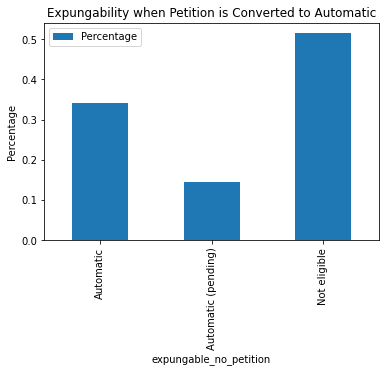

In [10]:
# Graph of Expungability without Petition
df_percentages_no_petition.plot.bar(x=None, y="Percentage")

plt.ylabel("Percentage")
plt.title("Expungability when Petition is Converted to Automatic")

### Expungability with Petition

In [11]:
# percentages with petition
df_percentages = pd.DataFrame(courtdata.groupby("expungable").size(), columns=['Count'])
df_percentages['Cumlative_Percent'] = 100*(df_percentages.Count.cumsum() / df_percentages.Count.sum())
df_percentages['Cumlative_Count'] = df_percentages.Count.cumsum()
df_percentages['Percentage'] = df_percentages.Count.apply(lambda x: x/df_percentages['Count'].sum())

df_percentages

,Count,Cumlative_Percent,Cumlative_Count,Percentage
expungable,,,,
Automatic,517,18.392031,517,0.183920
Automatic (pending),343,30.594095,860,0.122021
Not eligible,1448,82.106012,2308,0.515119
Petition,441,97.794379,2749,0.156884
Petition (pending),62,100.000000,2811,0.022056


Text(0.5, 1.0, 'Expungability with Petition')

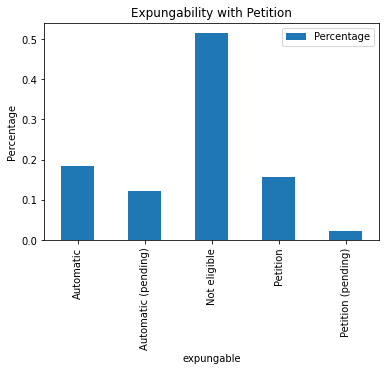

In [12]:
# Graph of Expungability with Petition
df_percentages.plot.bar(x=None, y="Percentage")

plt.ylabel("Percentage")
plt.title("Expungability with Petition")

# Graph 2: Percent Change when Petition is Converted to Automatic

In [13]:
# merge percentage tables
merged_percentages = df_percentages.reset_index()[["expungable", "Percentage"]].merge(df_percentages_no_petition.reset_index()[["expungable_no_petition", "Percentage"]], how="outer", left_on="expungable", right_on="expungable_no_petition", suffixes=["_w_pet", "_wo_pet"])
merged_percentages

# convert nan to 0
merged_percentages.fillna(0, inplace=True)
merged_percentages

# drop the expungable_no_petition column
merged_percentages.drop(columns=["expungable_no_petition"], inplace=True)
merged_percentages

# add difference column
merged_percentages["percent_difference"] = merged_percentages["Percentage_wo_pet"] - merged_percentages["Percentage_w_pet"]
merged_percentages


,expungable,Percentage_w_pet,Percentage_wo_pet,percent_difference
0,Automatic,0.183920,0.340804,0.156884
1,Automatic (pending),0.122021,0.144077,0.022056
2,Not eligible,0.515119,0.515119,0.000000
3,Petition,0.156884,0.000000,-0.156884
4,Petition (pending),0.022056,0.000000,-0.022056


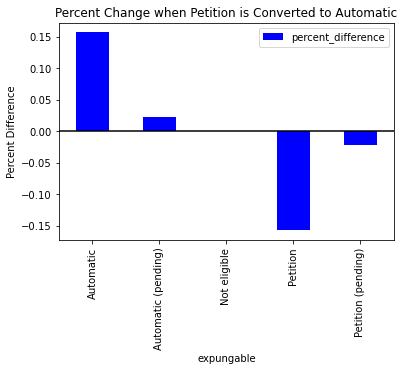

In [14]:
# Graph Percent Change when Petition is Converted to Automatic
merged_percentages.plot.bar(x="expungable", y="percent_difference", color="blue")

plt.ylabel("Percent Difference")
plt.title("Percent Change when Petition is Converted to Automatic")
plt.axhline(color="black")


# Graph 3: Expungbility by Race

###  Expunbability by Race without Petition

In [15]:
courtdata.stb.freq(['Race'])

,Race,count,percent,cumulative_count,cumulative_percent
0,White Caucasian(Non-Hispanic),1093,38.882960,1093,38.882960
1,Black(Non-Hispanic),864,30.736393,1957,69.619353
2,White Caucasian (Non-Hispanic),342,12.166489,2299,81.785841
3,Black (Non-Hispanic),311,11.063678,2610,92.849520
4,Hispanic,88,3.130559,2698,95.980078
5,Other(Includes Not Applicable.. Unknown),27,0.960512,2725,96.940591
6,Asian Or Pacific Islander,27,0.960512,2752,97.901103
7,White,17,0.604767,2769,98.505870
8,Unknown (Includes Not Applicable.. Unknown),11,0.391320,2780,98.897190
9,MISSING,10,0.355745,2790,99.252935


In [16]:
replace_map = {'Black(Non-Hispanic)':'Black (Non-Hispanic)', 
               'White Caucasian(Non-Hispanic)':'White (Non-Hispanic)', 
               'Other(Includes Not Applicable.. Unknown)':'Other',
               'White Caucasian (Non-Hispanic)':'White (Non-Hispanic)',
               'Unknown (Includes Not Applicable.. Unknown)':'Other', 
               'NA':'Other',
               'Asian Or Pacific Islander':'Asian or Pacific Islander', 
               'Black (Non-Hispanic)':'Black (Non-Hispanic)', 
               'White':'White (Non-Hispanic)',
               'American Indian':'American Indian or Alaskan Native', 
               'Unknown':'Other',
               'Other (Includes Not Applicable.. Unknown)':'Other', 
               'Black':'Black (Non-Hispanic)',
               'American Indian or Alaskan Native':'American Indian or Alaskan Native',
               'American Indian Or Alaskan Native':'American Indian or Alaskan Native', 
               'Asian or Pacific Islander':'Asian or Pacific Islander'}
courtdata.Race = courtdata.Race.replace(replace_map)
courtdata.stb.freq(['Race'])

,Race,count,percent,cumulative_count,cumulative_percent
0,White (Non-Hispanic),1452,51.654216,1452,51.654216
1,Black (Non-Hispanic),1185,42.155816,2637,93.810032
2,Hispanic,88,3.130559,2725,96.940591
3,Other,46,1.636428,2771,98.577019
4,Asian or Pacific Islander,27,0.960512,2798,99.537531
5,MISSING,10,0.355745,2808,99.893276
6,American Indian or Alaskan Native,3,0.106724,2811,100.000000


In [17]:
rowtable_no_petition = (pd.crosstab(courtdata.Race, courtdata.expungable_no_petition, normalize='index')*100).round(2).reset_index()
rowtable_no_petition

expungable_no_petition,Race,Automatic,Automatic (pending),Not eligible
0,American Indian or Alaskan Native,66.67,33.33,0.00
1,Asian or Pacific Islander,55.56,22.22,22.22
2,Black (Non-Hispanic),27.34,11.56,61.10
3,Hispanic,45.45,27.27,27.27
4,MISSING,70.00,30.00,0.00
5,Other,47.83,23.91,28.26
6,White (Non-Hispanic),37.74,15.36,46.90


Text(0, 0.5, 'Percentage')

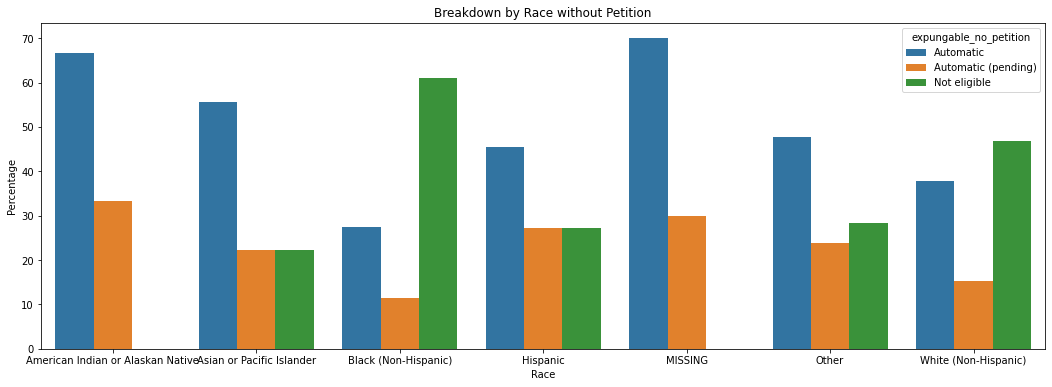

In [18]:
# graph by race without petition
barplot = pd.melt(rowtable_no_petition,
                  id_vars = ['Race'],
                  value_vars = ['Automatic', 'Automatic (pending)', 'Not eligible'])

plt.figure(figsize=(18, 6))
sns.barplot(x='Race', y='value', hue='expungable_no_petition', data=barplot).set(title="Breakdown by Race without Petition")

plt.ylabel("Percentage")

### Expunbability by Race with Petition

In [19]:
rowtable = (pd.crosstab(courtdata.Race, courtdata.expungable, normalize='index')*100).round(2).reset_index()
rowtable

expungable,Race,Automatic,Automatic (pending),Not eligible,Petition,Petition (pending)
0,American Indian or Alaskan Native,66.67,33.33,0.00,0.00,0.00
1,Asian or Pacific Islander,44.44,18.52,22.22,11.11,3.70
2,Black (Non-Hispanic),11.90,9.87,61.10,15.44,1.69
3,Hispanic,35.23,26.14,27.27,10.23,1.14
4,MISSING,70.00,30.00,0.00,0.00,0.00
5,Other,26.09,21.74,28.26,21.74,2.17
6,White (Non-Hispanic),21.49,12.67,46.90,16.25,2.69


Text(0, 0.5, 'Percentage')

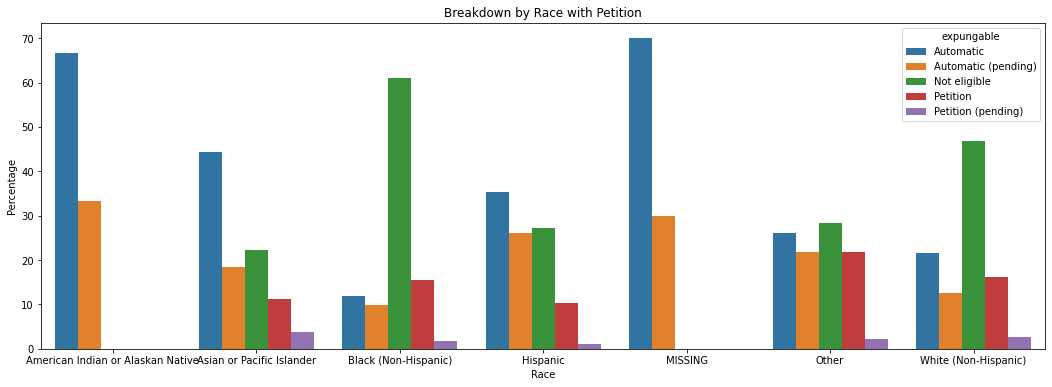

In [20]:
# graph by race with petition
barplot = pd.melt(rowtable,
                  id_vars = ['Race'],
                  value_vars = ['Automatic', 'Automatic (pending)', 'Not eligible', 'Petition', 'Petition (pending)'])

plt.figure(figsize=(18, 6))
sns.barplot(x='Race', y='value', hue='expungable', data=barplot).set(title="Breakdown by Race with Petition")

plt.ylabel("Percentage")

# Graph 4: Percent Change by Race when Petition is Converted to Automatic

In [21]:
# # merge percentage tables
# merged_percentages = rowtable.reset_index().merge(rowtable_no_petition.reset_index(), how="outer", on="Race", suffixes=["_w_pet", "_wo_pet"])
# merged_percentages

# # convert nan to 0
# merged_percentages.fillna(0, inplace=True)
# merged_percentages


# # add columns for petition and petittio
# # drop the expungable_no_petition column
# merged_percentages.drop(columns=["expungable_no_petition"], inplace=True)
# merged_percentages

# # add difference column
# merged_percentages["percent_difference"] = merged_percentages["Percentage_wo_pet"] - merged_percentages["Percentage_w_pet"]
# merged_percentages

## Evaluate Code Sections in 100k Sample 

In [23]:
## grab court data
myquery = """
    SELECT * FROM public.data_100k_sample
    """
courtdata_100k = pd.read_sql(myquery, con=conn)

In [25]:
# courtdata_100k.head()

In [26]:
# courtdata.groupby(["codesection", "expungable"]).count()
codesection_data = courtdata_100k[["codesection", "expungable", "person_id"]].groupby(["codesection", "expungable"]).count().rename(columns={"person_id": "counts"})
codesection_data


counts
codesection               expungable                 
covered elsewhere         Automatic             43463
                          Automatic (pending)   31566
                          Not eligible         143649
                          Petition              41099
                          Petition (pending)     4814
covered in 19.2-392.6 - A Automatic                 6
                          Not eligible             14
covered in 19.2-392.6 - B Automatic              4125
                          Automatic (pending)    1933
                          Not eligible          14932
                          Petition               5943
                          Petition (pending)      687
excluded by 19.2-392.12   Automatic               117
                          Automatic (pending)       7
                          Not eligible            776
                          Petition                385
                          Petition (pending)       82

In [27]:
codesection_data.reset_index()

,codesection,expungable,counts
0,covered elsewhere,Automatic,43463
1,covered elsewhere,Automatic (pending),31566
2,covered elsewhere,Not eligible,143649
3,covered elsewhere,Petition,41099
4,covered elsewhere,Petition (pending),4814
5,covered in 19.2-392.6 - A,Automatic,6
6,covered in 19.2-392.6 - A,Not eligible,14
7,covered in 19.2-392.6 - B,Automatic,4125
8,covered in 19.2-392.6 - B,Automatic (pending),1933
9,covered in 19.2-392.6 - B,Not eligible,14932


In [29]:
# # graph by race with petition
# barplot = pd.melt(codesection_data,
#                   id_vars = ['expungable'],
#                   value_vars = ['Automatic', 'Automatic (pending)', 'Not eligible', 'Petition', 'Petition (pending)'])

# plt.figure(figsize=(18, 6))
# sns.barplot(x='codesection', y='value', hue='expungable', data=barplot).set(title="Breakdown by Race with Petition")

# plt.ylabel("Percentage")